In [2]:
#Import Library
import sys
import os
import shutil
import glob
import cv2
import numpy as np
from tqdm.auto import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [3]:
#데이터를 배열로 초기화
# data = {}
# data['crack'] = []
# data['uncrack'] = []

In [4]:
#Crack Data
# src = 'archive/Positive'
# for jpgImage in glob.iglob(os.path.join(src, '*jpg')):
#     data['crack'].append(jpgImage)
# print(len(data['crack']))

In [5]:
#Uncrack Data
# src = 'archive/Negative'
# for jpgImage in glob.iglob(os.path.join(src, '*jpg')):
#     data['uncrack'].append(jpgImage)
# print(len(data['uncrack']))

In [6]:
#Create File
# os.mkdir('master_data_concrete')
# os.mkdir('master_data_concrete/train')
# os.mkdir('master_data_concrete/test')
# os.mkdir('master_data_concrete/valid')

# os.mkdir('master_data_concrete/train/crack')
# os.mkdir('master_data_concrete/train/uncrack')
# os.mkdir('master_data_concrete/test/crack')
# os.mkdir('master_data_concrete/test/uncrack')
# os.mkdir('master_data_concrete/valid/crack')
# os.mkdir('master_data_concrete/valid/uncrack')


In [7]:
#Data shuffle

# X = data['crack'] #Data
# Y = np.zeros((len(data['crack']))) #Labels

# #train : validation = 60 : 40
# X_T, X_test, Y_T, Y_test = train_test_split(X,Y, test_size=0.2)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_T, Y_T, test_size=0.4)
# # assert len(X_train) == len(data['crack'])/10*6

# #Data Check
# print('X_train Data list =',len(X_train), '   X_train Label list =',len(Y_train))
# print('X_valid Data list =',len(X_valid), '   X_valid Label list =',len(Y_valid))
# print('X_test Data list =',len(X_test), '   X_test Label list =',len(Y_test))

In [8]:
#image copy

# base_dest = 'master_data_concrete'

# #copy training  images of crack type
# for image in tqdm(X_train):
#         dest = os.path.join(base_dest, 'train', 'crack')
#         shutil.copy(image, dest)

# #copy testing images of crack type
# for image in tqdm(X_test):
#         dest = os.path.join(base_dest, 'test', 'crack')
#         shutil.copy(image, dest)
        
# for image in tqdm(X_valid):
#     dest = os.path.join(base_dest, 'valid', 'crack')
#     shutil.copy(image, dest)

In [9]:
#Data shuffle
# X = data['uncrack'] #Data
# Y = np.zeros((len(data['uncrack']))) #Labels

# #train : validation = 60 : 40
# X_T, X_test, Y_T, Y_test = train_test_split(X,Y, test_size=0.2)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_T, Y_T, test_size=0.4)
# # assert len(X_train) == len(data['crack'])/10*6

# #Data Check
# print('X_train Data list =',len(X_train), '   X_train Label list =',len(Y_train))
# print('X_valid Data list =',len(X_valid), '   X_valid Label list =',len(Y_valid))
# print('X_test Data list =',len(X_test), '   X_test Label list =',len(Y_test))

In [10]:
#image copy

# base_dest = 'master_data_concrete'

# #copy training  images of crack type
# for image in tqdm(X_train):
#         dest = os.path.join(base_dest, 'train', 'uncrack')
#         shutil.copy(image, dest)

# #copy testing images of crack type
# for image in tqdm(X_test):
#         dest = os.path.join(base_dest, 'test', 'uncrack')
#         shutil.copy(image, dest)
        
# for image in tqdm(X_valid):
#     dest = os.path.join(base_dest, 'valid', 'uncrack')
#     shutil.copy(image, dest)

In [11]:
data = 'master_data_concrete'
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.Grayscale(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])
train_dataset = datasets.ImageFolder(data + '/train', transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.Grayscale(),
                                      transforms.ToTensor()
                                     ])
valid_dataset = datasets.ImageFolder(data + '/valid', transform=valid_transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.Grayscale(),
                                      transforms.ToTensor(),
                                    ])
test_dataset = datasets.ImageFolder(data + '/test', transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [13]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # convolutional layer (sees 112 x 112 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.bn1 = torch.nn.BatchNorm2d(16)
        
        self.bn2 = torch.nn.BatchNorm2d(32)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (56 * 56 * 32 -> 500)
        self.fc1 = nn.Linear(56 * 56 * 32, 500)
        # linear layer (500 -> 2)
        self.fc2 = nn.Linear(500, 2)
        
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        # flatten image input
        x = x.view(-1, 56 * 56 * 32)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x),dim=1)
        return x

# create a complete CNN
model = Net()
train_on_gpu = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    print("Use Cuda!!")

Use Cuda!!


In [14]:
summary(model, (a.shape[1],a.shape[2],a.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
           Dropout-7               [-1, 100352]               0
            Linear-8                  [-1, 500]      50,176,500
           Dropout-9                  [-1, 500]               0
           Linear-10                    [-1, 2]           1,002
Total params: 50,182,398
Trainable params: 50,182,398
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 21.45
Params size (MB): 191.43
Es

In [15]:
def train(n_epochs, model, train_loader, train_on_gpu, optimizer, criterion, valid_loader):
    valid_loss_min = np.Inf # track change in validation loss
    t_loss = []
    v_loss = []
    for epoch in tqdm(range(1, n_epochs+1), desc='Epoch : '):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in tqdm(train_loader, desc='Train : ', leave=False):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        with torch.no_grad():
            model.eval()
            for data, target in tqdm(valid_loader, desc='Validation : ', leave=False):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
    return t_loss, v_loss, model

In [15]:
n_epochs = 10
train_loader = train_dataloader
train_on_gpu = torch.cuda.is_available()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
valid_loader = valid_dataloader
train_loss, valid_loss, model = train(n_epochs, model, train_loader, train_on_gpu, optimizer, criterion, valid_loader)

Epoch :   0%|          | 0/10 [00:00<?, ?it/s]

Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.125394 	Validation Loss: 0.086225
Validation loss decreased (inf --> 0.086225).  Saving model ...


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.037321 	Validation Loss: 0.028606
Validation loss decreased (0.086225 --> 0.028606).  Saving model ...


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.022927 	Validation Loss: 0.033721


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.031639 	Validation Loss: 0.019940
Validation loss decreased (0.028606 --> 0.019940).  Saving model ...


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.009349 	Validation Loss: 0.022403


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.010009 	Validation Loss: 0.027890


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.012028 	Validation Loss: 0.030653


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.009176 	Validation Loss: 0.024736


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.005109 	Validation Loss: 0.045065


Train :   0%|          | 0/1920 [00:00<?, ?it/s]

Validation :   0%|          | 0/1280 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.005340 	Validation Loss: 0.025708


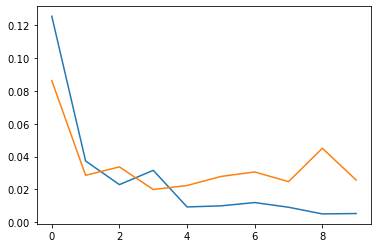

In [16]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [16]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [17]:
def test(batch_size, model, test_dataloader, train_on_gpu, criterion, classes):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    # iterate over test data
    for data, target in tqdm(test_dataloader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

# Test

In [19]:
train_on_gpu = torch.cuda.is_available()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
batch_size = 10
classes = ['Crack', 'Uncrack']
test(batch_size, model, test_dataloader, train_on_gpu, criterion, classes)

  0%|          | 0/800 [00:00<?, ?it/s]

Test Loss: 0.013554

Test Accuracy of Crack: 99% (3973/4000)
Test Accuracy of Uncrack: 99% (3990/4000)

Test Accuracy (Overall): 99% (7963/8000)
